# Training Overview

The goal here is to learn a low-dimensional function which encodes the waveform (amplitude) of the surf.

We have the following to work with:
1. A normalized greyscale video tensor of shape (y,x,t)
1. An incomplete supervisory signal tensor which correlates to high-amplitude (the foam wavefronts of broken waves) of shape (y,x,t)

The eventual goal here is to learn a mapping from `greyscale_video_tensor` to a function `amplitude(x,y,t)` which respects various known physical constraints on the waveform. Learning this waveform will give us the ability to train better wave detection models and infer more information about the surfbreak such as bathometry (shape of the ocean floor).

## Verifying the Setup
Initially, we want to verify the basic assumptions and get this working in 1 spatial dimension (a vertical slice in the calibrated video) and 1 time dimension. 

In this simplified setting, the amplitude function would look like $amplitude = f(x, t)$

We may want to start by parameterizing f(x,t) using an set of fourier kernels as used in this paper:
https://github.com/tancik/fourier-feature-networks

From that paper, the input encoder for a 1-dimensional fit is: 
```
input_encoder = lambda x, a, b: np.concatenate([a * np.sin((2.*np.pi*x[...,None]) * b), 
                                                a * np.cos((2.*np.pi*x[...,None]) * b)], axis=-1) / np.linalg.norm(a)
```

The general steps to follow (using only a vertical slice of the input video) are:
1. Test the concept initially by directly regressing f(x,t) on the encoded supervisory signal. 
1. Apply some physics domain knowledge (see `01_wave_modeling.ipynb`) to regularize the regressed waveform.
1. Learn to regress from the normalized video itself, using the supervisory signal only as a piece of the loss function (instead of as input).


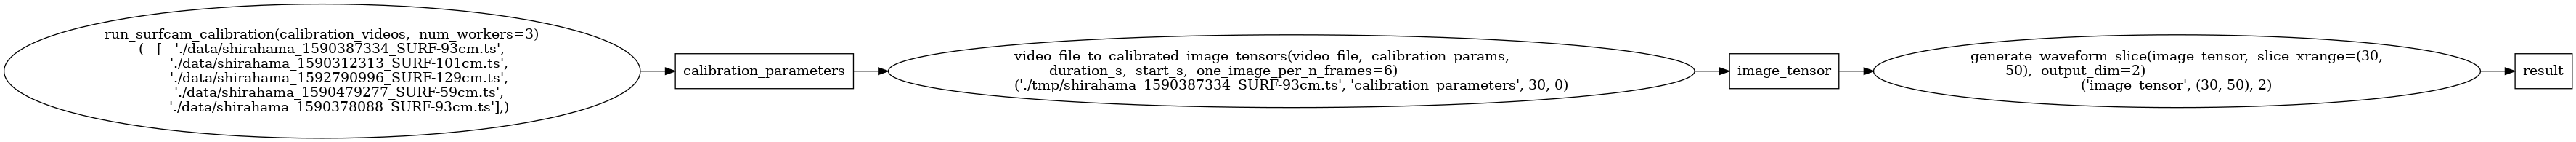

In [ ]:
%load_ext autoreload
%autoreload 2
from surfbreak import graphutils, supervision
import pipelines
import graphchain
import dask
import matplotlib.pyplot as plt

show_image = supervision.show_image

# TODO: Improve this pipeline to chunk the image_tensor (memory usage...). 

# These tensors are 10hz by default (1/6th of the frames from a of 60Hz video)
waveform_slice_graph = pipelines.video_to_waveform_slice('./tmp/shirahama_1590387334_SURF-93cm.ts',
                                                                duration_s=30, start_s=0)

graphutils.visualize(waveform_slice_graph)

### Define the inputs

In [ ]:
img_tensor = graphchain.get(waveform_slice_graph, "image_tensor")
wavefront_tensor = supervision.dilate_tensor(supervision.wavefront_diff_tensor(img_tensor))
supervision.animate_tensor(wavefront_tensor[...,::5])

(139, 297)


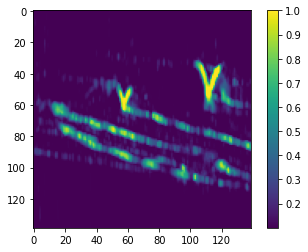

In [ ]:
waveform_slice = graphchain.get(waveform_slice_graph, "result").astype('float32')
print(waveform_slice.shape)
ydim = waveform_slice.shape[0]
test_slice = waveform_slice[:,:ydim]
plt.imshow(test_slice)
plt.colorbar()

## Next Steps
1. Get the basic SIREN 2d image fitting model working from https://vsitzmann.github.io/siren/
1. Figure out how to imbue this model with physics constraints in the (y,time) dimensions

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image
import explore_siren as siren

def get_test_slice_tensor(sidelength):
    waveform_slice_graph = pipelines.video_to_waveform_slice('./tmp/shirahama_1590387334_SURF-93cm.ts',
                                                                duration_s=30, start_s=0)
    waveform_slice = graphchain.get(waveform_slice_graph, "result").astype('float32')
    ydim = waveform_slice.shape[0]
    test_slice = waveform_slice
    img = Image.fromarray(test_slice)        
    transform = Compose([
        Resize((sidelength,sidelength)),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_test_slice_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = siren.get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError

        return self.coords, self.pixels

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


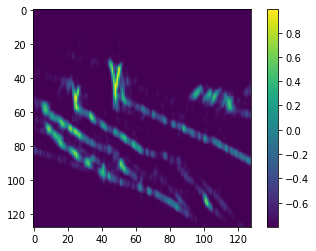

In [ ]:
waveform = ImageFitting(sidelength=128)
dataloader = DataLoader(waveform, batch_size=1, pin_memory=True, num_workers=0)
model_input, ground_truth = next(iter(dataloader))
plt.imshow(ground_truth.reshape(128,128))
plt.colorbar()

### Define cost function which only penalizes missing peaks

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


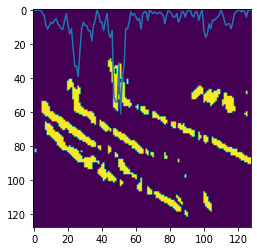

In [ ]:
dataloader = DataLoader(waveform, batch_size=1, pin_memory=True, num_workers=0)
model_input, ground_truth = next(iter(dataloader))
high_amp_mask = ground_truth > (ground_truth.mean() + ground_truth.std())
plt.imshow(high_amp_mask.reshape(128,128))
plt.plot(((high_amp_mask.reshape(128,128).sum(dim=0))**2)/20)
plt.show()

#### Define cost for average zero wave amplitude in space-time windows

windows: torch.Size([1, 7, 7])


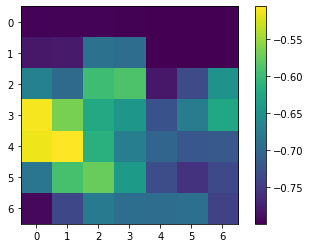

In [ ]:
import torch
import math
from torch.nn import functional as f

def image_to_strided_buckets(batched_img, image_dim=128, pix_per_bucket=40):
    x = batched_img.reshape(-1, image_dim,image_dim)
    stride = pix_per_bucket//2
    # Expands a rolling window of kernel_size, with 50% overlap between windows
    ufx = f.unfold(x[None, ...], kernel_size=pix_per_bucket, stride=stride)
    #print("ufx:", ufx.shape)
    bucket_means = ufx.mean(dim=1)
    #print("bm: ", bucket_means.shape)
    # Average over all elements in the windows
    n_buckets = int(math.sqrt(ufx.shape[-1]))
    windows = bucket_means.reshape(1, x.shape[0]//stride - 1,x.shape[1]//stride - 1)
    return windows

windows = image_to_strided_buckets(ground_truth, pix_per_bucket=30)
print("windows:", windows.shape)
plt.imshow(windows[0])
plt.colorbar()
plt.show()

#### Also conserve change in amplitude between Y-dimension buckets over time

First, approximate to ideal 1-dimensional problem in time. We know waves move with monotonic, decreasing velocity. 
For now *assume constant wave speed* in vertical pixel space (the perspective of the image counteracts the actual decreasing speed)
Have this wave speed (dy/dt) be a learnable parameter - inially fixed, later varying smoothly as a function of y. 

Amplitude in a cell at one timestep should either:
1. Remain in that cell until the next timestep (cell to the right)
1. Move to the next cell on the next timestep (cell to the bottom-right)
1. Enter from the cell above in the previous timestep (upper-left)

Steps to calculate cost function:
1. Find delta-amplitude in time of cell above
1. Find delta-amplitude in time of cell
1. Find delta-amplitude in time of cell below
1. Sum of the above three should be ~ zero if cells are larger than the amplitude peaks

This will result in large costs for horizontal (stationary amplitude), and vertical (

### Training loop

In [ ]:
def fit_waveform_slice(first_omega_0=1, lossfunc='mse', total_steps=401, steps_til_summary=100):
    img_dim = 128
    waveform = ImageFitting(img_dim)
    dataloader = DataLoader(waveform, batch_size=1, pin_memory=True, num_workers=0)

    img_siren = siren.Siren(in_features=2, out_features=1, hidden_features=128, 
                    hidden_layers=3, outermost_linear=True, first_omega_0=1, dydt=0.65)
    img_siren.cuda()

    """We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well."""

    total_steps = total_steps # Since the whole image is our dataset, this just means 500 gradient descent steps.
    n_plots = total_steps//steps_til_summary + 1
    fig, axes = plt.subplots(2, n_plots, figsize=(3*n_plots,3*2), sharex=True, sharey=True)
    plt.tight_layout

    optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

    for step in range(total_steps):
        model_output, coords = img_siren(model_input)
        if lossfunc is 'mse':
            loss = ((model_output - ground_truth)**2).mean()
        elif lossfunc is 'ampmask':
            # Push average amplitude to 0 for all groups of 40pix x 0.4s (20x20 from y,t input coodinates)
            yt_buckets = image_to_strided_buckets(model_output, image_dim=img_dim, pix_per_bucket=30)
            amplitude_window_loss = (yt_buckets.reshape(model_output.shape[0],-1)**2).sum()
            
            # wavespeed loss:  constant velocity wave-speed
            delta_time = 0.1 # Unitless time = 1/20 of full window
            dydt = img_siren.dydt
            delta_time_pix = int(delta_time * img_dim)
            delta_y_pix = int(dydt * delta_time * img_dim)
            
            #shifted_coords = torch.stack((coords[...,0] + delta_time * dydt, coords[...,1] + delta_time), dim=-1)
            # Run these coordinates through the model to get a shifted version of the target image
            #shift_model_output, coords2 = img_siren(shifted_coords)
            
            # Do this with pixel shifting for now (since coordinates have their gradients truncated, and forward pass is slow)
            model_output_asimg = model_output.reshape(-1, img_dim, img_dim)
            wavespeed_loss = ((model_output_asimg[...,delta_y_pix:, delta_time_pix:] -
                               model_output_asimg[...,:-delta_y_pix, :-delta_time_pix])**2).mean()*4
            
            # Push amplitude in masked areas above 1
            high_amp_mask = ground_truth > (ground_truth.mean() + ground_truth.std())
            loss_mask = (((model_output - 1).clamp(min=-10, max=0)**2)*high_amp_mask).mean()*100            
            
            # Low amplitude gradients (and higher-order laplace = gradient's gradient)
            grad_loss    =  siren.gradient(model_output, coords).abs().mean()*0.1
            laplace_loss =  siren.laplace(model_output, coords).abs().mean()*0.01
            
            loss = amplitude_window_loss + loss_mask + wavespeed_loss + grad_loss + laplace_loss

        if not step % steps_til_summary:
            if lossfunc is 'mse':
                print("Step %d, Total loss %0.6f" % (step, loss))
            else:
                print("Step %d, Total loss %0.6f" % (step, loss), " window: {:.6f}, mask:{:.6f}, wavespeed:{:.6f} (dydt={:.6f}), grad:{:0.6f}, laplace:{:0.6f}"
                      .format(amplitude_window_loss, loss_mask, wavespeed_loss, dydt, grad_loss, laplace_loss))
                
            img_grad = siren.gradient(model_output, coords)
            img_laplacian = siren.laplace(model_output, coords)
            img = model_output.cpu().view(img_dim,img_dim).detach().numpy()
            axes[0][step//steps_til_summary].set_title("Step "+str(step) + " ({:.2f},{:.2f})".format(img.min(), img.max()))
            axes[0][step//steps_til_summary].imshow(model_output.cpu().view(img_dim,img_dim).detach().numpy())
            img_grad = img_grad.norm(dim=-1).cpu().view(img_dim,img_dim).detach().numpy()
            axes[1][step//steps_til_summary].set_title("Grad: ({:.2f},{:.2f})".format(img_grad.min(), img_grad.max()))
            axes[1][step//steps_til_summary].imshow(img_grad)
            #axes[2][step//steps_til_summary].imshow(img_laplacian.cpu().view(img_dim,img_dim).detach().numpy())

        optim.zero_grad()
        loss.backward()
        optim.step()
    plt.show()
    return img_siren.cpu()

In [ ]:
from surfbreak.train_utils import dump_tensors
dump_tensors()

Total size: 0


/home/erik/work/surfbreak/surfbreak/train_utils.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  elif hasattr(obj, "data") and torch.is_tensor(obj.data):
/home/erik/work/surfbreak/surfbreak/train_utils.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  elif hasattr(obj, "data") and torch.is_tensor(obj.data):


Step 0, Total loss 0.604105
Step 100, Total loss 0.043714
Step 200, Total loss 0.039994
Step 300, Total loss 0.035630
Step 400, Total loss 0.026715


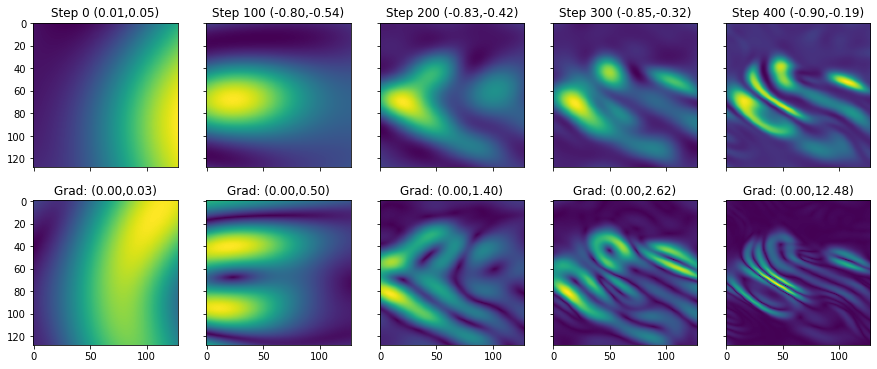

In [ ]:
siren_model = fit_waveform_slice()
del(siren_model)
torch.cuda.empty_cache()

Step 0, Total loss 8.038747  window: 0.123617, mask:7.914406, wavespeed:0.000016 (dydt=0.650000), grad:0.000580, laplace:0.000127
Step 100, Total loss 3.817709  window: 0.857618, mask:2.145734, wavespeed:0.194717 (dydt=0.650000), grad:0.175829, laplace:0.443811
Step 200, Total loss 2.737411  window: 0.417343, mask:0.815023, wavespeed:0.325495 (dydt=0.650000), grad:0.299836, laplace:0.879714
Step 300, Total loss 2.636827  window: 0.374408, mask:0.706274, wavespeed:0.329745 (dydt=0.650000), grad:0.318943, laplace:0.907456
Step 400, Total loss 2.569959  window: 0.342654, mask:0.662817, wavespeed:0.328094 (dydt=0.650000), grad:0.326550, laplace:0.909844


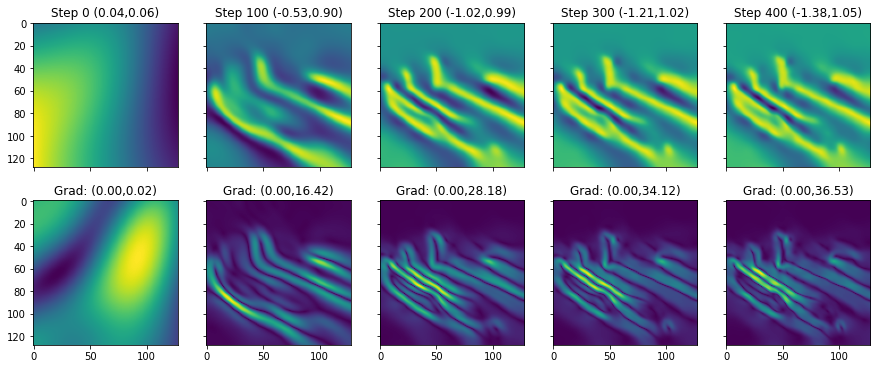

In [ ]:
# 4x dydt, 10x laplac
ampmask_model = fit_waveform_slice(first_omega_0=0.1, lossfunc='ampmask', total_steps=401, steps_til_summary=100)
torch.cuda.empty_cache()